# Analyse exploratoire 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from scipy.spatial.distance import hamming
from sklearn.metrics import pairwise_distances
from Levenshtein import distance as lev

from biopandas.pdb import PandasPdb
from Bio.PDB import PDBParser
import nglview as nv

In [2]:
pd.set_option("display.max_columns", 30)

## Chargement des données

In [3]:
train = pd.read_csv("Data/train_correct.csv") 
test = pd.read_csv("Data/test.csv")

In [4]:
print("train shape : ", train.shape)
print("test shape : ", test.shape)

train shape :  (28981, 5)
test shape :  (2413, 4)


In [5]:
train.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [6]:
test.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


Les protéines du fichiers test sont des variants d'une même enzyme, donc les différentes sequences de protéine sont très proches. Ce  n'est pas le cas du fichier train, mais nous allons voir au cours de ce notebook qu'il y a quand même des groupes de variants dans ce fichier. 

## Nettoyage

Nous n'avons pas besoin des 'data_source'.

In [7]:
train.drop('data_source', axis=1, inplace=True)
test.drop('data_source', axis=1, inplace=True)

Il y a des doublons dans le fichier train. On les supprime. 

In [8]:
train.drop_duplicates(subset='protein_sequence', inplace=True)
train.shape

(27375, 4)

On supprime les lignes avec des données manquantes.

In [9]:
train.dropna(inplace=True)
train.shape

(27117, 4)

Passons à l'exploration des données. L'analyse exploratoire des données numériques fournies va être rapide puisqu'il n'y a que le pH et la variable cible tm de train. Le point essentiel de ce notebook sera la création de nouvelles variables à partir des séquences des protéines.

## pH et tm

In [10]:
train[['pH', 'tm']].describe()

,pH,tm
count,27117.000000,27117.000000
mean,6.942945,51.278759
std,0.600389,12.051977
min,1.990000,25.100000
25%,7.000000,43.600000
50%,7.000000,48.700000
75%,7.000000,54.200000
max,11.000000,130.000000


<AxesSubplot: xlabel='pH', ylabel='Count'>

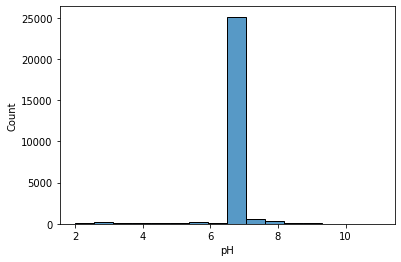

In [11]:
sns.histplot(data=train, x='pH')

<AxesSubplot: xlabel='tm', ylabel='Count'>

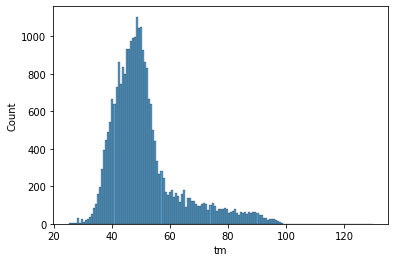

In [12]:
sns.histplot(data=train, x='tm')

In [13]:
test['pH'].value_counts()

8    2413
Name: pH, dtype: int64

Pour test il n'y a rien à tracer puisque le pH vaut toujours 8.

## Séquences des protéines

Il y a deux approches possibles suivant que l'on s'autorise ou non à récupérer des données en dehors des fichiers fournis. En effet on nous a fourni un fichier pdb contenant des informations sur l'enzyme de test et on pourrai rechercher les fichiers pdb relatifs aux protéines de train. Mais cela va poser quelques problèmes. D'une part cela fera un gros volume de données à manipuler, mais surtout il faut des connaissances spécifiques pour manipuler des fichiers pdb et pour savoir quelles données sont susceptibles d'être utiles. Nous n'utiliserons donc pas cette approche, mais nous allons voir brièvement quelques possibilités offertes par le fichier pdb.

### Le fichier pdb

In [14]:
pdb = PandasPdb().read_pdb("Data/wildtype_structure_prediction_af2.pdb")

Le fichier pdb nous donne accès à un dictionnaire.

In [15]:
type(pdb.df)

dict

In [16]:
pdb.df.keys()

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])

Ce dictionnaire contient un dataframe qui nous renseigne sur la structure atomique de la protéine.

In [17]:
pdb.df['ATOM']

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,VAL,,A,1,,,34.064,-6.456,50.464,1.0,45.11,,,N,NaN,0
1,ATOM,2,,H,,VAL,,A,1,,,33.576,-6.009,51.228,1.0,45.11,,,H,NaN,1
2,ATOM,3,,H2,,VAL,,A,1,,,33.882,-7.449,50.477,1.0,45.11,,,H,NaN,2
3,ATOM,4,,H3,,VAL,,A,1,,,35.060,-6.323,50.566,1.0,45.11,,,H,NaN,3
4,ATOM,5,,CA,,VAL,,A,1,,,33.643,-5.877,49.162,1.0,45.11,,,C,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,ATOM,3313,,NZ,,LYS,,A,221,,,4.616,13.323,-4.301,1.0,93.80,,,N,NaN,3312
3313,ATOM,3314,,HZ1,,LYS,,A,221,,,5.270,12.565,-4.432,1.0,93.80,,,H,NaN,3313
3314,ATOM,3315,,HZ2,,LYS,,A,221,,,4.585,13.517,-3.310,1.0,93.80,,,H,NaN,3314
3315,ATOM,3316,,HZ3,,LYS,,A,221,,,4.965,14.143,-4.776,1.0,93.80,,,H,NaN,3315


On peut également visualiser la protéine.

In [18]:
pdb_parser = PDBParser()
structure = pdb_parser.get_structure("PHA-L","Data/wildtype_structure_prediction_af2.pdb")

In [19]:
view = nv.show_biopython(structure)
view

NGLWidget()

Nous n'irons pas plus loin dans l'utilisation de ce fichier. L'approche de ce notebook est plutôt de considérer les protéines comme de simples chaînes de caractères (avec une variable numérique 'pH' associée), comme s'il n'y avait pas de contexte biologique.

Commençons par quelque chose de très simple: la longueur des séquences.

### Longueur

Affichons la première séquence de test en entier.

In [20]:
train['protein_sequence'].iloc[0]

'AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVGMIKDAGDDPDVTHGAEIQAFVRFASEDRLEGGEGVGVVTKPGLGVPVGEPAINPVPRRMIWEAVREVTERPLAVTIAIPGGEELAKKTLNPRLGILGGLSVLGTTGVVKPYSTSAFRMSVVQAVGVARANGLLEIAATTGGKSERFAQRLLPHLPEMAFIEMGDFVGDVLRAARKVGVEVVRVVGMIGKISKMADGKTMTHAAGGEVNLSLLLSLLKEAGASPKALKEAEGAATARRFLEIALEEGLELFFVNLVRLAQEKLQAYIGERPFVSVALTDFDEGRCLAAWPDREVYR'

Ajoutons une nouvelle variable à train.

In [21]:
train['protein_length'] = train['protein_sequence'].apply(lambda x: len(x))

<AxesSubplot: xlabel='protein_length', ylabel='Count'>

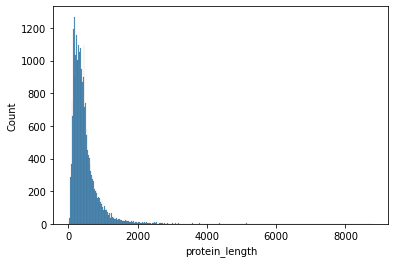

In [22]:
sns.histplot(data=train, x='protein_length')

Le pH ne variait pas assez pour tracer 'tm' en fonction du pH, mais 'protein_length' varie suffisamment.

<AxesSubplot: xlabel='protein_length', ylabel='tm'>

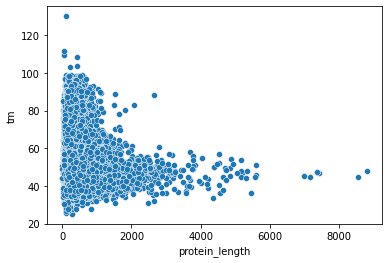

In [23]:
sns.scatterplot(data=train, x="protein_length", y="tm")

Comme les protéines de test sont des variants d'une même enzyme, elles devraient toutes avoir à peut près la même longueur.

In [24]:
test['protein_sequence'].apply(lambda x: len(x)).value_counts()

221    2336
220      77
Name: protein_sequence, dtype: int64

Une fois de plus on voit que les données de test sont très différentes des données de train. Cela nous suggère qu'il va être difficile de faire de bonnes prédictions sur test avec un entraînement sur train.

Nous allons supprimer les protéines de plus de 1000 acides aminés du fichier train parce qu'il n'y en a pas beaucoup, qu'elles sont très différentes des protéines de test et qu'elles pourraient nous faire perdre en efficacité par la suite (notamment lors d'un ajout de variables ultérieur).

In [25]:
train = train[train['protein_length']<1000]
train.shape

(25177, 5)

<AxesSubplot: xlabel='protein_length', ylabel='Count'>

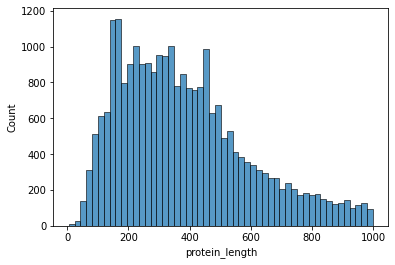

In [26]:
sns.histplot(data=train, x='protein_length')

Nous allons voir ensuite quelles sont les différents caractères (acides aminés) qui composent ces séquences.

## Acides aminées

In [27]:
amino_count = train['protein_sequence'].str.split('').explode('protein_sequence').value_counts().drop('')
amino_count

L    910999
A    742560
E    688730
S    660799
G    660011
V    635510
K    597705
D    534103
I    528047
R    516243
T    500077
P    471037
N    401995
Q    398555
F    373084
Y    291839
M    228067
H    217438
C    135498
W    108771
Name: protein_sequence, dtype: int64

In [28]:
len(amino_count.index)

20

Text(0, 0.5, '')

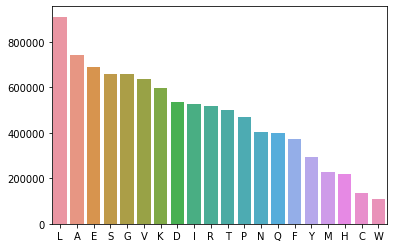

In [29]:
sns.barplot(x=amino_count.index, y=amino_count).set_ylabel('')

Nous auront besoin par la suite d'encoder les différents acides aminés, donc on les garde en mémoire dans une liste.

In [30]:
amino_list = list(amino_count.index)
amino_list.sort()

Passons maintenant à la partie la plus importante de ce notebook.

## Protéines et mutations

L'objectif est de trouver dans le fichier train, s'il y en a, des groupes de protéines qui sont des variants d'une même protéine. Des variants se caractérisent par une distance de Levenshtein faible entre eux, mais il va être long de calculer les distances de Levenshtein pour tous les couples de protéines de train donc il va falloir faire attention à la façon de procéder. En particulier, la fonction 'pairwise_distances' de scikit-learn (qui est optimisée pour ce type de calcul) ne fonctionne pas avec la distance de Levenshtein.

La distance de Hamming n'est pas tout à fait ce qu'il nous faut pour trouver les variants, mais elle a l'avantage d'être utilisable avec 'pairwise_distances'.

On va commencer par tester nos outils (distances de Hamming et de Levenshtein) sur le fichier test car on sait qu'il s'agit de variants d'une même protéine.

### test

In [31]:
test

,seq_id,protein_sequence,pH
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8


Nous allons calculer les matrices des distances entre les couples de protéines, pour les deux distances. Nous regarderons en plus les temps de calcul.

#### Distance de Hamming

La distance de Hamming nécessite un autre format de données que des chaînes de caractères.

In [32]:
df = pd.DataFrame(test['protein_sequence'].apply(list).tolist())
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220
0,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
1,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
2,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K,None
3,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
4,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
2409,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
2410,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
2411,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K


Il faut ensuite encoder les lettres par des valeurs numériques.

In [33]:
amino_dict = {k: i+1 for i, k in enumerate(amino_list)}
amino_dict[None] = 0

In [34]:
df = df.replace(amino_dict)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220
0,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
1,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
2,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,NaN
3,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
4,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
2409,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
2410,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
2411,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0


In [35]:
df = df.fillna(0)
df = df.astype(int)

In [36]:
X = df.values
X

array([[18, 13, 18, ..., 18,  6,  9],
       [18, 13, 18, ..., 18,  6,  9],
       [18, 13, 18, ...,  6,  9,  0],
       ...,
       [18, 13, 18, ..., 18,  6,  9],
       [18, 13, 18, ..., 18,  6,  9],
       [18, 13, 18, ..., 18,  6,  9]])

Calculons maintenant la matrice des distances de Hamming.

In [37]:
start_time = timeit.default_timer()

hamming_test_matrix = pairwise_distances(X, metric=hamming)
    
temps = timeit.default_timer() - start_time
print(temps)

17.3620861


In [38]:
hamming_test_matrix

array([[0.        , 0.00452489, 0.89140271, ..., 0.00904977, 0.00904977,
        0.00904977],
       [0.00452489, 0.        , 0.88687783, ..., 0.00904977, 0.00904977,
        0.00904977],
       [0.89140271, 0.88687783, 0.        , ..., 0.8959276 , 0.8959276 ,
        0.8959276 ],
       ...,
       [0.00904977, 0.00904977, 0.8959276 , ..., 0.        , 0.00452489,
        0.00452489],
       [0.00904977, 0.00904977, 0.8959276 , ..., 0.00452489, 0.        ,
        0.00452489],
       [0.00904977, 0.00904977, 0.8959276 , ..., 0.00452489, 0.00452489,
        0.        ]])

Il y a des distances très élevées (0.89). Elles correspondent à un décalage dans la séquence de protéine, comme on peut le voir à la fin de la 3ème ligne (index 2) de df. Donc on risque effectivement de manquer des variants si on utilise cette distance.

In [39]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220
0,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9
1,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9
2,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,0
3,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9
4,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9


Passons à la distance de Lenvenshtein.

#### Distance de Levenshtein

In [40]:
n = test.shape[0]

In [41]:
levenshtein_test_matrix = np.full((n, n), 0)

In [42]:
start_time = timeit.default_timer()
for i in range(n):
    for j in range(i+1, n):
        levenshtein_test_matrix[i][j] = lev(test['protein_sequence'].iloc[i], test['protein_sequence'].iloc[j])
temps = timeit.default_timer() - start_time
print(temps)

25.19349239999997


Le fichier train contient 10 fois plus de protéines et comme il y a deux boucles le temps de calcul pour train devrait être environ 100 fois plus élevé (sans prendre en compte la différence de longueur des séquences).

In [43]:
# temps de calcul estimé pour train, en minutes
temps*100/60

41.98915399999995

In [44]:
levenshtein_test_matrix

array([[0, 1, 1, ..., 2, 2, 2],
       [0, 0, 1, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

On a en fait calculé seulement la moitée triangulaire supérieure de la matrice, mais c'est suffisant parce que c'est une matrice symétrique de diagonale nulle.

In [45]:
levenshtein_test_matrix = levenshtein_test_matrix + levenshtein_test_matrix.T
levenshtein_test_matrix

array([[0, 1, 1, ..., 2, 2, 2],
       [1, 0, 1, ..., 2, 2, 2],
       [1, 1, 0, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 0, 1, 1],
       [2, 2, 2, ..., 1, 0, 1],
       [2, 2, 2, ..., 1, 1, 0]])

In [46]:
levenshtein_test_matrix.max()

2

On peut donc considérer qu'une distance de Levenshtein "faible" pour caractériser des variants est une distance de Levenshtein inférieure ou égale à 2, ou disons plutôt 3 pour prendre un peu de marge.

### train

On veut calculer les distances de Levenshtein entre des séquences de plusieurs centaines de caractère (en générale) mais il est raisonnable de penser qu'on peut se contenter seulement d'un morceau de la chaîne. En effet il y a 20 acides aminés différents donc en considérant seulement les 20 premiers caractères on a un nombre de possibilités égale à:

In [47]:
20**20

104857600000000000000000000

Ce qui est largement supérieur au nombre de protéine dans train. On va donc calculer les distance entre les premiers 20-grams.

In [48]:
def tronc_str(x, n):
    if len(x) < n:
        return x
    else:
        return x[:n]

In [49]:
train['first_20'] = train['protein_sequence'].apply(lambda x: tronc_str(x, 20))

In [50]:
train

,seq_id,protein_sequence,pH,tm,protein_length,first_20
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,AAAAKAAALALLGEAPEVVD
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,AAADGEPLHNEEERAGAGQV
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,AAAFSTPRATSYRILSSAGS
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,AAASGLRTAIPAQPLRHLLQ
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,AACFWRRTVIPKPPFRGIST
...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,YYMYSGGGSALAAGGGGAGR
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,YYNDQHRLSSYSVETAMFLS
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,YYQRTLGAELLYKISFGEMP
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,593,YYSFSDNITTVFLSRQAIDD


Si on calcul la matrice des distances alors il faudra par la suite récupérer les indices des couples de distance faible et les regrouper. En fait ce n'est pas la matrice qui nous intéresse, mais seulement le regroupement. On va donc plutôt effectuer le regroupement sans passer par la matrice des distances. Comme on sait que le calcul va être long, on va d'abord faire des tests sur une partie seulement de train pour s'assurer qu'il ne faudra pas des jours de calcul.

In [51]:
copy_train = train.copy()

In [52]:
def time_to_compute(n):
    '''
    Renvoie le temps nécessaire pour regrouper les variants au sein des couples (j, i) ou i parcours toutes les lignes de train,
    et j parcours seulement les n premières.
    '''
    dic = {} # keys: numéro de groupe, values: liste des index des protéines du groupe
    n_group = 1
    start_time = timeit.default_timer()
    for j in range(n) : # ligne destinée à être remplacer par la suite
        l = []
        a = copy_train['first_20'].iloc[0]
        for i in copy_train.index:
            if lev(a, copy_train['first_20'].loc[i]) <= 3:
                l.append(i)
        dic[n_group] = l
        n_group += 1
        copy_train.drop(l, axis=0, inplace=True) # on supprime les protéines déjà regroupées

    temps = timeit.default_timer() - start_time
    return temps

In [53]:
time_to_compute(10)

1.6028023000000076

In [54]:
copy_train = train.copy()
time_to_compute(100)

15.287812299999985

In [55]:
copy_train = train.copy()
temps = time_to_compute(1000)
temps

161.77599320000007

La complexité semble être linéaire. On peut donc estimer le temps de calcul pour le fichier train complet à 25 fois le temps précédent (train contient environ 25 x 1000 lignes).  

In [56]:
temps*25/60 # en minutes

67.40666383333335

On peut espérer un temps beaucoup plus court si des groupes importants de variants sont détectés assez tôt dans la boucle.

In [57]:
# le vrai code
copy_train = train.copy()
dic = {}
n_group = 1
start_time = timeit.default_timer()
while copy_train.shape[0] > 0 :
    l = []
    a = copy_train['first_20'].iloc[0]
    for i in copy_train.index:
        if lev(a, copy_train['first_20'].loc[i])<= 3:
            l.append(i)
    dic[n_group] = l
    n_group += 1
    copy_train.drop(l, axis=0, inplace=True)
    
temps = timeit.default_timer() - start_time
print(temps)

1804.38987


In [99]:
temps / 60

30.0731645

Remarque: les temps de calcul dépendent évidemment de la puissance de la machine qui les exécute, mais ils peuvent aussi varier d'une exécution à l'autre sur une même machine à cause d'éventuelles taches en arrière plan, et ces variations peuvent être importantes (on peut même voir disparaître la linéarité lors des test avec 10, 100 et 1000 lignes).

Pour éviter de déterminer les groupes à chaque fois on va les sauvegarder dans un fichier csv.

In [58]:
liste = [dic[i] for i in dic.keys()]
d = {'col1': liste}
groupes = pd.DataFrame(data=d, index=dic.keys())
groupes

,col1
1,[0]
2,[1]
3,[2]
4,[3]
5,"[5, 6]"
...,...
21789,[28976]
21790,[28977]
21791,[28978]
21792,[28979]


In [59]:
groupes.to_csv('Data/groupes_train.csv', index = False)

In [60]:
# Pour récupérer les groupes sans refaire le calcul
groupes = pd.read_csv("Data/groupes_train.csv")

In [61]:
groupes

,col1
0,[0]
1,[1]
2,[2]
3,[3]
4,"[5, 6]"
...,...
21788,[28976]
21789,[28977]
21790,[28978]
21791,[28979]


In [62]:
groupes['col1'] = groupes['col1'].apply(lambda x: eval(x))

On ajoute une varaible pour contenir les numéros de groupe des protéines.

In [63]:
train['groupe'] = np.nan

In [64]:
for i in range(groupes.shape[0]):
    for j in groupes['col1'].values[i]:
        train['groupe'].loc[j] = i

C:\Users\tony.mathieux\AppData\Local\Temp\ipykernel_33932\778510808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['groupe'].loc[j] = i


In [65]:
train

,seq_id,protein_sequence,pH,tm,protein_length,first_20,groupe
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,AAAAKAAALALLGEAPEVVD,0.0
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,AAADGEPLHNEEERAGAGQV,1.0
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,AAAFSTPRATSYRILSSAGS,2.0
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,AAASGLRTAIPAQPLRHLLQ,3.0
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,AACFWRRTVIPKPPFRGIST,4.0
...,...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,YYMYSGGGSALAAGGGGAGR,21788.0
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,YYNDQHRLSSYSVETAMFLS,21789.0
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,YYQRTLGAELLYKISFGEMP,21790.0
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,593,YYSFSDNITTVFLSRQAIDD,21791.0


In [66]:
train['groupe'] = train['groupe'].astype('int')

Vérifions s'il existe dans train un variant de l'enzyme de test.

In [67]:
l = []
for i in range(train.shape[0]):
    l.append(lev(test['protein_sequence'].iloc[0], train['protein_sequence'].iloc[i]))
min(l)

162

Non, il n'y en a pas. Donc on va ajouter à test une variable 'groupe' valant un numéro qui ne désigne aucun groupe de train.

In [68]:
test['groupe'] = train['groupe'].max() + 1

## Les groupes de mutation de train

Une question importante dont on veut une réponse est: est-ce que des variants d'une même protéine peuvent avoir des températures de fusion très différentes?

On regardera aussi la variation de pH au sein d'un groupe.

In [69]:
group_train = train.groupby(['groupe'])
group_train = group_train.agg({
    'seq_id': 'count',
    'pH': 'mean',
    'tm': 'mean'
})

In [70]:
group_train

,seq_id,pH,tm
groupe,,,
0,1,7.0,75.70
1,1,7.0,50.50
2,1,7.0,40.50
3,1,7.0,47.20
4,2,7.0,47.05
...,...,...,...
21788,1,7.0,51.80
21789,1,7.0,37.20
21790,1,7.0,64.60


In [71]:
group_train['seq_id'].value_counts()

1      20925
2        679
3         69
4         32
5         12
6          8
8          6
10         6
14         4
7          4
9          4
12         3
15         3
37         3
25         3
32         2
27         2
74         2
78         1
211        1
19         1
28         1
26         1
21         1
56         1
48         1
52         1
46         1
292        1
16         1
34         1
143        1
31         1
45         1
17         1
84         1
122        1
50         1
38         1
62         1
57         1
35         1
49         1
30         1
Name: seq_id, dtype: int64

Il y a beaucoup de protéines isolés mais il y a quand même quelques groupes. Pour que l'analyse soit significative il nous faut des groupes assez conséquants. On va considérer les groupe de plus de 100 protéines.

In [72]:
group_train = group_train[group_train['seq_id'] > 100]
group_train

,seq_id,pH,tm
groupe,,,
10195,122,2.756557,61.601639
12181,143,6.921538,47.646853
12462,292,4.108938,51.886644
13004,211,8.000000,61.988626


Regardons quelques groupes, ce qui nous permettra de voir au passage si nous ne nous somme pas manifestement trompé dans notre algorithme de regroupement.

In [73]:
train[train['groupe'] == 12462]

,seq_id,protein_sequence,pH,tm,protein_length,first_20,groupe
16160,18020,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,38.1,164,MNAFEMLRIDERLRLKIYKD,12462
16200,18060,MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,41.9,164,MNCFEMLRIDERLRLKIYKD,12462
16211,18071,MNDFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,4.2,53.3,164,MNDFEMLRIDERLRLKIYKD,12462
16252,18112,MNEFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,37.8,164,MNEFEMLRIDERLRLKIYKD,12462
16311,18171,MNFFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,34.1,164,MNFFEMLRIDERLRLKIYKD,12462
...,...,...,...,...,...,...,...
17785,19771,MNSFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,34.9,164,MNSFEMLRIDERLRLKIYKD,12462
17861,19847,MNTFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,3.0,49.2,164,MNTFEMLRIDERLRLKIYKD,12462
17909,19899,MNVFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,39.8,164,MNVFEMLRIDERLRLKIYKD,12462
17957,19949,MNWFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,6.5,56.7,164,MNWFEMLRIDERLRLKIYKD,12462


In [74]:
train[train['groupe'] == 13004]

,seq_id,protein_sequence,pH,tm,protein_length,first_20,groupe
17494,19480,MNQSVKSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...,8.0,62.5,455,MNQSVKSLPEKDIQYQLHPY,13004
17495,19481,MNQSVSSLAEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...,8.0,64.0,455,MNQSVSSLAEKDIQYQLHPY,13004
17496,19482,MNQSVSSLKEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...,8.0,63.5,455,MNQSVSSLKEKDIQYQLHPY,13004
17497,19483,MNQSVSSLPEKDIQYQLHPYTDARLHQELGPLIIERGEGIYVYDDQ...,8.0,62.0,455,MNQSVSSLPEKDIQYQLHPY,13004
17498,19484,MNQSVSSLPEKDIQYQLHPYTEARLHQELGPLIIERGEGIYVYDDQ...,8.0,61.5,455,MNQSVSSLPEKDIQYQLHPY,13004
...,...,...,...,...,...,...,...
17700,19686,MNQSVSSLPEKDIQYQLHPYTNARLHQKLGPLIIERGEGIYVYDDQ...,8.0,62.5,455,MNQSVSSLPEKDIQYQLHPY,13004
17701,19687,MNQSVSSLPEKDIQYQLHPYTNARLMQELGPLIIERGEGIYVYDDQ...,8.0,62.0,455,MNQSVSSLPEKDIQYQLHPY,13004
17702,19688,MNQSVSSLPEKDIQYQLHPYTNLRLHQELGPLIIERGEGIYVYDDQ...,8.0,62.0,455,MNQSVSSLPEKDIQYQLHPY,13004
17703,19689,MNQSVSSLPEKDKQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...,8.0,62.0,455,MNQSVSSLPEKDKQYQLHPY,13004


In [75]:
list_100 = list(group_train.index)
list_100

[10195, 12181, 12462, 13004]

On va regarder les pH et tm par groupes.

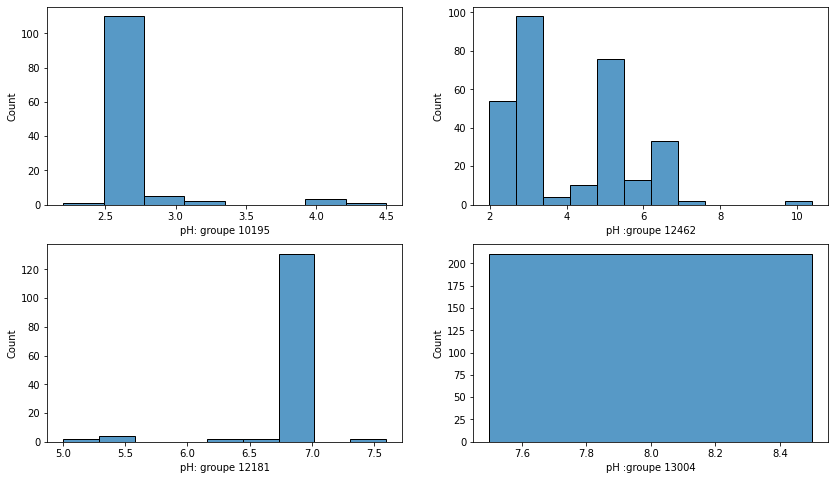

In [76]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for i in range(2):
    sns.histplot(data=train[train['groupe'] == list_100[i]], x='pH', ax=axs[i, 0]).set(xlabel='pH: groupe ' + str(list_100[i]))

for i in range(2): 
    sns.histplot(data=train[train['groupe'] == list_100[i+2]], x='pH', ax=axs[i, 1]).set(xlabel='pH :groupe ' + str(list_100[i+2]))

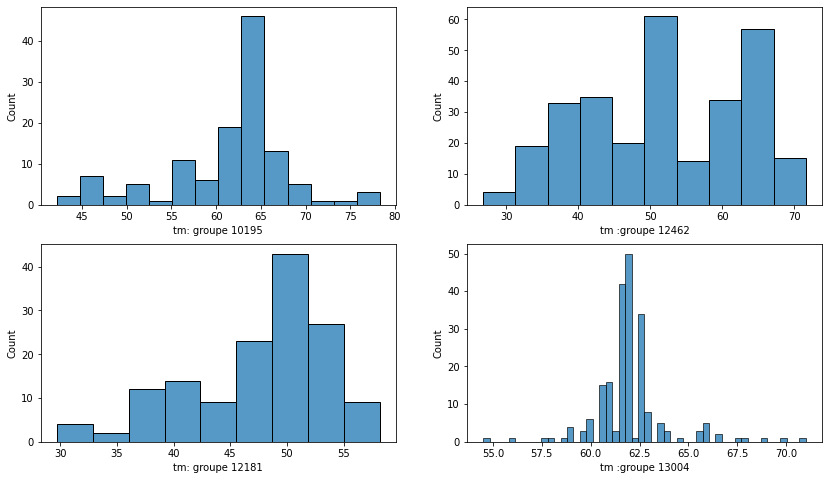

In [77]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for i in range(2):
    sns.histplot(data=train[train['groupe'] == list_100[i]], x='tm', ax=axs[i, 0]).set(xlabel='tm: groupe ' + str(list_100[i]))

for i in range(2):
    sns.histplot(data=train[train['groupe'] == list_100[i+2]], x='tm', ax=axs[i, 1]).set(xlabel='tm :groupe ' + str(list_100[i+2]))

<AxesSubplot: xlabel='tm', ylabel='groupe'>

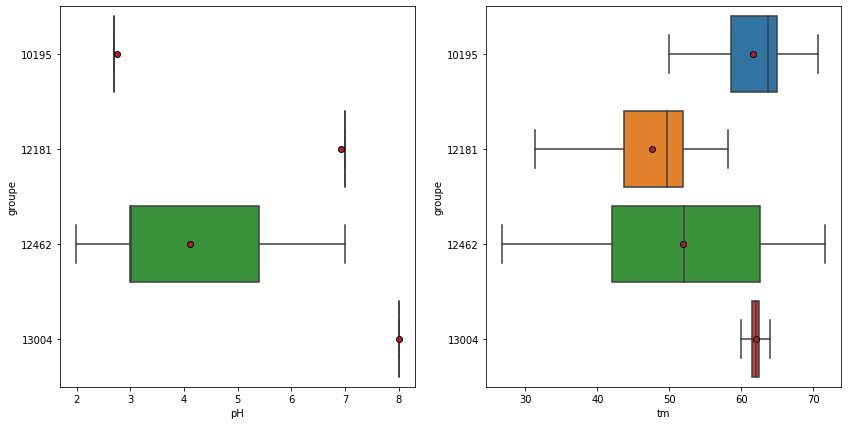

In [78]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
# Un point rouge indiquera la moyenne dans les boxplot

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.boxplot(x="pH", y="groupe", showfliers=False, showmeans=True, meanprops=meanprops,
            orient='h', data=train[train['groupe'].isin(list_100)], ax=axs[0])
sns.boxplot(x="tm", y="groupe", showfliers=False, showmeans=True, meanprops=meanprops,
            orient='h', data=train[train['groupe'].isin(list_100)], ax=axs[1])

Les valeurs de pH et de tm peuvent donc fortement varier entre des protéines très similaires.

## Ajout de variables

Nous allons ajouter de nouvelles variables à nos données, suivant deux approches qui fourniront deux dataframes très différents. Les approches diffèrent par le fait que l'on prenne ou non en compte l'ordre des acides aminées dans les séquences.

### Première approche

L'idée est simplement de compter le nombre de chacun des 20 acides aminés possibles. 

In [79]:
train1 = train.copy()
train1

,seq_id,protein_sequence,pH,tm,protein_length,first_20,groupe
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,AAAAKAAALALLGEAPEVVD,0
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,AAADGEPLHNEEERAGAGQV,1
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,AAAFSTPRATSYRILSSAGS,2
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,AAASGLRTAIPAQPLRHLLQ,3
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,AACFWRRTVIPKPPFRGIST,4
...,...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,YYMYSGGGSALAAGGGGAGR,21788
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,YYNDQHRLSSYSVETAMFLS,21789
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,YYQRTLGAELLYKISFGEMP,21790
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,593,YYSFSDNITTVFLSRQAIDD,21791


On n'a plus besoin de 'first_20', ni de la longueur des séquences car cette longueur est égale à la somme des quantités de chacun des acides aminés.

In [80]:
train1.drop(['first_20', 'protein_length'], axis=1, inplace=True)

In [81]:
def count_amino(prot, am):
    count = len([l for l in prot if l==am])
    return count

In [82]:
for amino in amino_list:
    train1[amino] = train1['protein_sequence'].apply(lambda x: count_amino(x, amino))

In [83]:
train1

,seq_id,protein_sequence,pH,tm,groupe,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,0,45,1,13,30,13,38,3,14,16,37,8,5,18,6,25,11,14,37,4,3
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,1,28,0,10,52,6,18,4,13,19,23,2,6,8,22,30,14,12,13,3,3
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,2,50,9,27,32,21,65,11,16,39,18,6,15,20,25,31,33,30,30,3,16
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,3,20,5,19,29,12,16,7,10,17,28,2,9,16,9,10,16,19,14,3,4
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,4,33,4,16,19,16,33,9,16,27,33,11,13,19,8,16,22,25,41,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,21788,33,12,38,31,18,51,15,21,32,46,13,24,25,24,42,33,18,42,13,18
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,21789,37,5,21,29,22,27,22,30,20,47,14,19,19,16,25,37,26,34,5,14
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,21790,13,1,7,7,7,11,2,6,8,6,7,5,6,8,3,10,6,7,4,4
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,21791,47,5,34,36,23,52,11,34,35,45,26,25,31,12,25,51,32,48,3,18


Dans d'autres cas on pourrait poursuivre en comptant les bigrams, trigrams... Mais là il y a 20 acides aminés possibles ce qui donne 20 x 20 = 400 bigrams possibles, sans compter qu'il faudrait décider de la façon de traiter un morceau comme 'AAAA' qui peut contenir 2 ou 3 bigrams 'AA' suivant le point de vu. On va donc se contenter des quantités de chacun des acides aminés.

Regardons la matrice des corrélations.

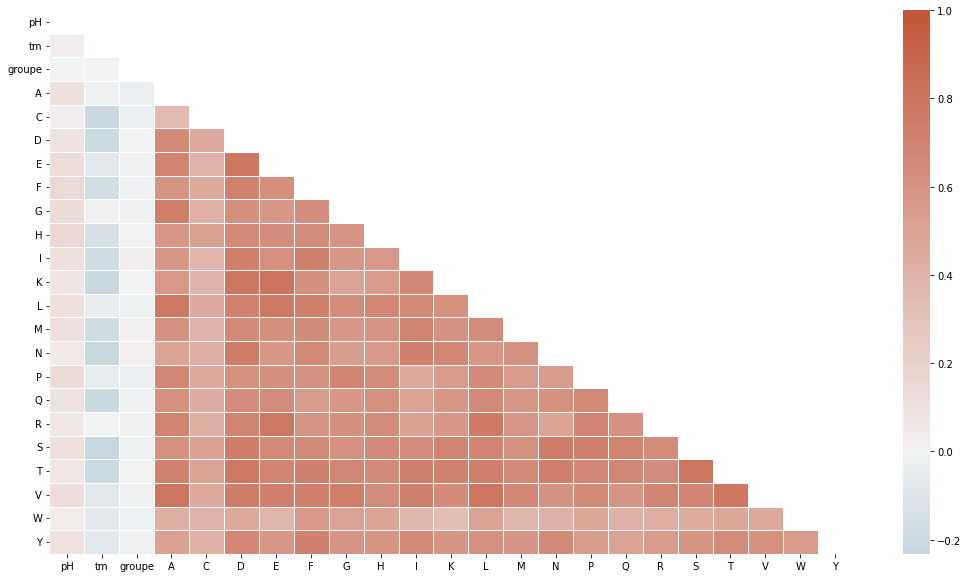

In [84]:
corr = train1.drop(['seq_id', 'protein_sequence'], axis=1).corr()

plt.figure(figsize=(18,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, linewidths=0.5)
plt.show()

On sauvegarde ce fichier.

In [85]:
train1.to_csv('Data/train_version1_for_modelisation.csv', index=False)

On créé un fichier analogue pour test.

In [86]:
test1 = test.copy()

In [87]:
for amino in amino_list:
    test1[amino] = test1['protein_sequence'].apply(lambda x: count_amino(x, amino))

In [88]:
test1

,seq_id,protein_sequence,pH,groupe,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,22,4,15,8,10,19,0,6,24,10,0,19,17,13,3,18,8,13,6,6
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,22,4,15,7,10,19,0,6,25,10,0,19,17,13,3,18,8,13,6,6
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,21793,22,4,15,7,10,19,0,6,24,10,0,19,17,13,3,18,8,13,6,6
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,22,5,15,7,10,19,0,6,23,11,0,19,17,13,3,18,8,13,6,6
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,22,4,15,7,11,19,0,6,23,11,0,19,17,13,3,18,8,13,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,21,4,15,7,10,19,0,7,24,11,0,19,17,13,3,18,8,13,6,6
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,21,4,15,7,10,19,0,6,24,12,0,19,17,13,3,18,8,13,6,6
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,21,4,15,7,10,19,0,6,24,11,0,20,17,13,3,18,8,13,6,6
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,21,4,15,7,10,19,0,6,24,11,0,19,18,13,3,18,8,13,6,6


In [89]:
test1.to_csv('Data/test_1_for_modelisation.csv', index=False)

### Deuxième approche

Dans cette approche les variables déduites des séquences de protéines sont les positions dans la séquence, et leurs valeurs possible sont les 20 acides aminés.

In [90]:
train2 = pd.DataFrame(train['protein_sequence'].apply(list).tolist())
train2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998
0,A,A,A,A,K,A,A,A,L,A,L,L,G,E,A,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,A,A,A,D,G,E,P,L,H,N,E,E,E,R,A,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,A,A,A,F,S,T,P,R,A,T,S,Y,R,I,L,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,A,A,A,S,G,L,R,T,A,I,P,A,Q,P,L,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,A,A,C,F,W,R,R,T,V,I,P,K,P,P,F,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25172,Y,Y,M,Y,S,G,G,G,S,A,L,A,A,G,G,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
25173,Y,Y,N,D,Q,H,R,L,S,S,Y,S,V,E,T,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
25174,Y,Y,Q,R,T,L,G,A,E,L,L,Y,K,I,S,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
25175,Y,Y,S,F,S,D,N,I,T,T,V,F,L,S,R,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [91]:
train2 = train2.replace(amino_dict)
train2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998
0,1,1,1,1,9,1.0,1.0,1.0,10.0,1.0,10.0,10.0,6.0,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,3,6,4.0,13.0,10.0,7.0,12.0,4.0,4.0,4.0,15.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,1,5,16,17.0,13.0,15.0,1.0,17.0,16.0,20.0,15.0,8.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,1,16,6,10.0,15.0,17.0,1.0,8.0,13.0,1.0,14.0,13.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2,5,19,15.0,15.0,17.0,18.0,8.0,13.0,9.0,13.0,13.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25172,20,20,11,20,16,6.0,6.0,6.0,16.0,1.0,10.0,1.0,1.0,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25173,20,20,12,3,14,7.0,15.0,10.0,16.0,16.0,20.0,16.0,18.0,4.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25174,20,20,14,15,17,10.0,6.0,1.0,4.0,10.0,10.0,20.0,9.0,8.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25175,20,20,16,5,16,3.0,12.0,8.0,17.0,17.0,18.0,5.0,10.0,16.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
train2.fillna(0, inplace=True)
train2 = train2.astype('int')
train2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998
0,1,1,1,1,9,1,1,1,10,1,10,10,6,4,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,3,6,4,13,10,7,12,4,4,4,15,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,5,16,17,13,15,1,17,16,20,15,8,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,16,6,10,15,17,1,8,13,1,14,13,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,2,5,19,15,15,17,18,8,13,9,13,13,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25172,20,20,11,20,16,6,6,6,16,1,10,1,1,6,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25173,20,20,12,3,14,7,15,10,16,16,20,16,18,4,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25174,20,20,14,15,17,10,6,1,4,10,10,20,9,8,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25175,20,20,16,5,16,3,12,8,17,17,18,5,10,16,15,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [93]:
train2 = pd.concat([train2, train.reset_index()['pH']], axis=1)

In [94]:
train2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,pH
0,1,1,1,1,9,1,1,1,10,1,10,10,6,4,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
1,1,1,1,3,6,4,13,10,7,12,4,4,4,15,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
2,1,1,1,5,16,17,13,15,1,17,16,20,15,8,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
3,1,1,1,16,6,10,15,17,1,8,13,1,14,13,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
4,1,1,2,5,19,15,15,17,18,8,13,9,13,13,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25172,20,20,11,20,16,6,6,6,16,1,10,1,1,6,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
25173,20,20,12,3,14,7,15,10,16,16,20,16,18,4,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
25174,20,20,14,15,17,10,6,1,4,10,10,20,9,8,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
25175,20,20,16,5,16,3,12,8,17,17,18,5,10,16,15,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0


In [95]:
train2.to_csv('Data/train_version2_for_modelisation.csv', index=False)

On créé un fichier analogue pour test.

In [96]:
test2 = pd.DataFrame(test['protein_sequence'].apply(list).tolist())
test2 = test2.replace(amino_dict)
test2.fillna(0, inplace=True)
test2 = test2.astype('int')

In [97]:
test2 = pd.concat([test2, test.reset_index()['pH']], axis=1)
test2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,207,208,209,210,211,212,213,214,215,216,217,218,219,220,pH
0,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,8
1,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,8
2,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,3,4,9,12,12,9,5,12,20,18,6,9,0,8
3,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,8
4,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,8
2409,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,8
2410,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,8
2411,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,8


In [98]:
test2.to_csv('Data/test_2_for_modelisation.csv', index=False)